# Tarea 3: GAN para Generación de Dígitos MNIST
## Fundamentos de Inteligencia Artificial

**Objetivo**: Implementar una Generative Adversarial Network (GAN) desde cero usando PyTorch para generar dígitos MNIST realistas.

**Nivel**: Avanzado

**Conceptos clave**:
- Arquitectura de GANs (Generador y Discriminador)
- Entrenamiento adversarial
- Espacio latente y generación
- Métricas de evaluación

**Instrucciones**: Completa las celdas marcadas con `# TODO`

## Parte 1: Importar librerías y configuración

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from tqdm import tqdm

# Configuración
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {DEVICE}")

# Semillas para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

# Hiperparámetros
BATCH_SIZE = 128
LEARNING_RATE = 0.0002
EPOCHS = 50
LATENT_DIM = 100  # Dimensión del espacio latente
IMAGE_SIZE = 784  # 28x28

Usando dispositivo: cpu


## Parte 2: Cargar y preparar datos

In [2]:
# Cargar MNIST
print("Cargando MNIST...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X = mnist["data"].values

# Usar un subconjunto para acelerar
n_samples = 20000
X = X[np.random.choice(len(X), n_samples, replace=False)]

# TODO: Normalizar los datos al rango [-1, 1]
# Pista: (X / 127.5) - 1
X = (X / 127.5) - 1

print(f"Shape de datos: {X.shape}")
print(f"Rango de valores: [{X.min():.2f}, {X.max():.2f}]")

Cargando MNIST...
Shape de datos: (20000, 784)
Rango de valores: [-1.00, 1.00]


In [3]:
# TODO: Crear DataLoader de PyTorch
# Pista: Convierte X a tensor de PyTorch y crea un TensorDataset

X_tensor = torch.FloatTensor(X)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

print(f"Número de batches: {len(dataloader)}")

Número de batches: 157


## Parte 3: Definir el Generador

In [4]:
# TODO: Implementar el Generador
# Arquitectura sugerida:
# - Input: LATENT_DIM
# - Output: IMAGE_SIZE neuronas + Tanh (para rango [-1, 1])

class Generator(nn.Module):
    def __init__(self, latent_dim, img_size):
        super(Generator, self).__init__()
        
        # COMPLETA: Define las capas del generador
        self.model = nn.Sequential(
            # Adiciona las capas del modelo
            # Capa de salida
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, img_size),
            nn.Tanh()  # Salida en rango [-1, 1]
        )
    
    def forward(self, z):
        # TODO: Implementa el forward pass
        img = self.model(z)
        return img

# Instanciar el generador
generator = Generator(LATENT_DIM, IMAGE_SIZE).to(DEVICE)
print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Tanh()
  )
)


## Parte 4: Definir el Discriminador

In [5]:
# TODO: Implementar el Discriminador
# Arquitectura sugerida:
# - Input: IMAGE_SIZE
# - Output: 1 neurona + Sigmoid (probabilidad de ser real)

class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        
        # COMPLETA: Define las capas del discriminador
        self.model = nn.Sequential(
            # Capas iniciales
            nn.Linear(img_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),

            # Capa de salida
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        # TODO: Implementa el forward pass
        validity = self.model(img)
        return validity

# Instanciar el discriminador
discriminator = Discriminator(IMAGE_SIZE).to(DEVICE)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


## Parte 5: Configurar optimizadores y función de pérdida

In [7]:
# TODO: Configurar optimizadores Adam para ambas redes
# Usar betas=(0.5, 0.999) que funcionan bien para GANs
lr = 0.0002

optimizer_G = optim.Adam(
    # COMPLETA: parámetros del generador y learning rate
    discriminator.parameters(), 
    lr=lr, 
    betas=(0.5, 0.999)
)

optimizer_D = optim.Adam(
    # COMPLETA: parámetros del discriminador y learning rate
    generator.parameters(), 
    lr=lr, 
    betas=(0.5, 0.999)
)

# TODO: Definir la función de pérdida (Binary Cross Entropy)
criterion = nn.BCELoss()

## Parte 6: Función auxiliar para generar imágenes

In [8]:
def generate_and_save_images(generator, epoch, latent_dim, n_images=25):
    """
    Genera y visualiza imágenes del generador
    """
    generator.eval()
    with torch.no_grad():
        # TODO: Generar ruido aleatorio del espacio latente
        z = torch.randn(n_images, latent_dim).to(DEVICE)
        
        # TODO: Generar imágenes
        generated_imgs = generator(z) # pasar z por el generador
        
        # Convertir a numpy y desnormalizar
        generated_imgs = generated_imgs.cpu().numpy()
        generated_imgs = (generated_imgs + 1) / 2  # De [-1, 1] a [0, 1]
    
    # Visualizar
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_imgs[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    
    plt.suptitle(f'Imágenes Generadas - Época {epoch}')
    plt.tight_layout()
    plt.show()
    
    generator.train()

## Parte 7: Loop de entrenamiento

Iniciando entrenamiento...


Época 1/50: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 92.33it/s]


Época [1/50] | D Loss: 5.6070 | G Loss: 0.0837


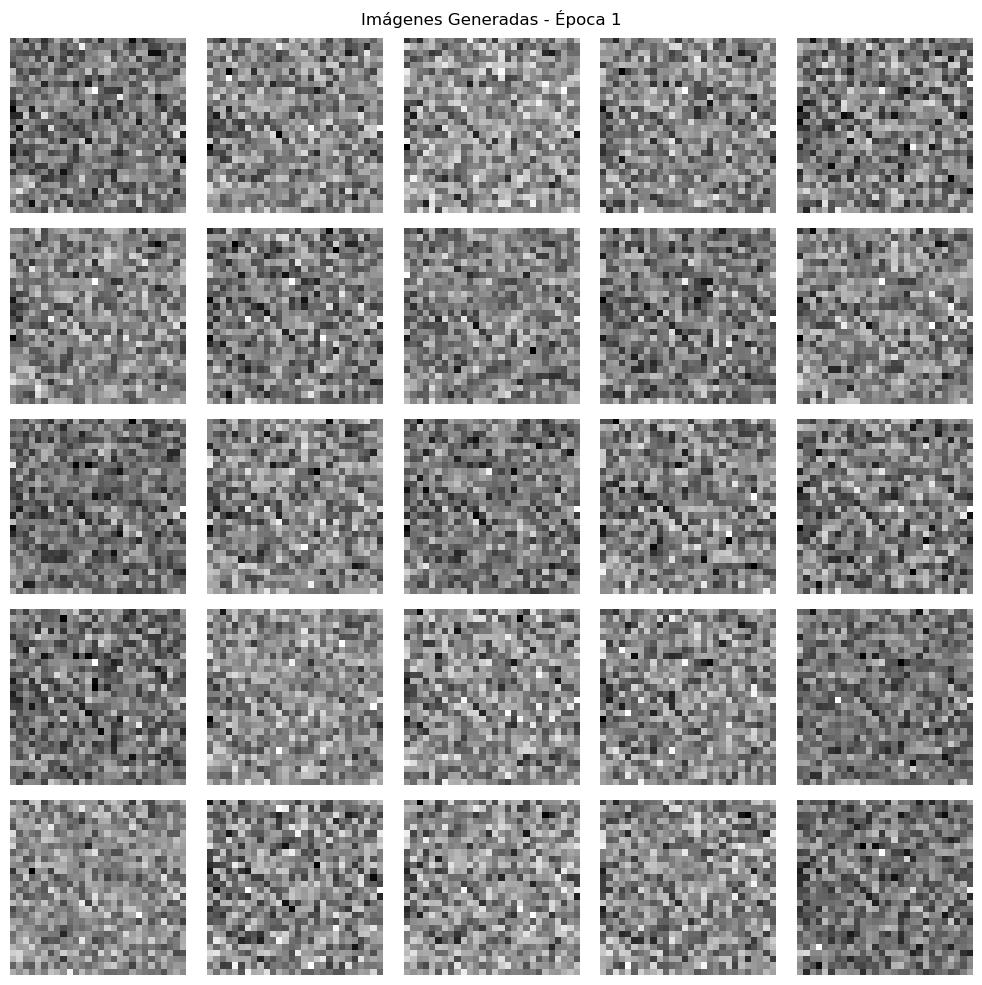

Época 2/50: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 95.03it/s]


Época [2/50] | D Loss: 8.8528 | G Loss: 0.0002


Época 3/50: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 98.52it/s]


Época [3/50] | D Loss: 9.9676 | G Loss: 0.0001


Época 4/50: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 97.26it/s]


Época [4/50] | D Loss: 10.6976 | G Loss: 0.0000


Época 5/50: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 97.45it/s]


Época [5/50] | D Loss: 11.2385 | G Loss: 0.0000


Época 6/50: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 97.79it/s]


Época [6/50] | D Loss: 11.6708 | G Loss: 0.0000


Época 7/50: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 96.60it/s]


Época [7/50] | D Loss: 12.0178 | G Loss: 0.0000


Época 8/50: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 97.29it/s]


Época [8/50] | D Loss: 12.3452 | G Loss: 0.0000


Época 9/50: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 94.10it/s]


Época [9/50] | D Loss: 12.6471 | G Loss: 0.0000


Época 10/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 96.47it/s]


Época [10/50] | D Loss: 12.9680 | G Loss: 0.0000


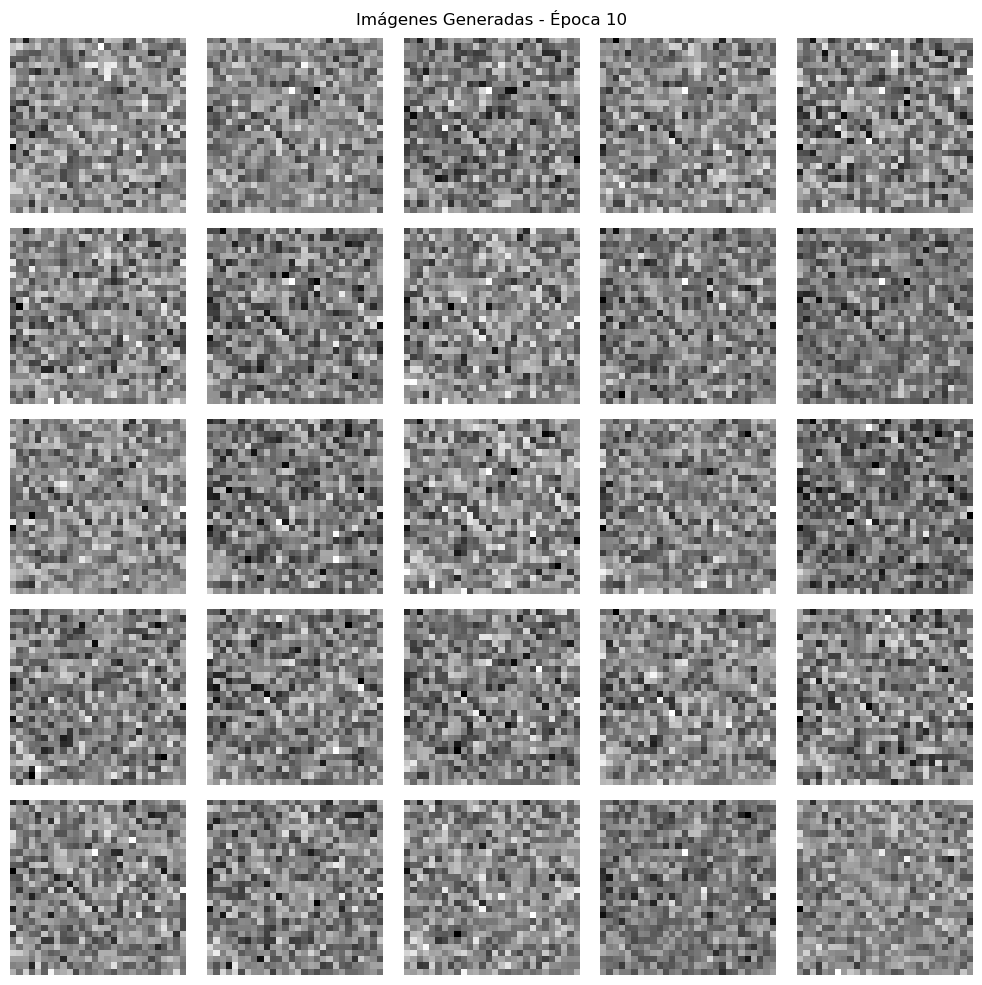

Época 11/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 93.80it/s]


Época [11/50] | D Loss: 13.2377 | G Loss: 0.0000


Época 12/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 96.75it/s]


Época [12/50] | D Loss: 13.5775 | G Loss: 0.0000


Época 13/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 95.51it/s]


Época [13/50] | D Loss: 13.9749 | G Loss: 0.0000


Época 14/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 87.15it/s]


Época [14/50] | D Loss: 14.3702 | G Loss: 0.0000


Época 15/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 94.68it/s]


Época [15/50] | D Loss: 14.9345 | G Loss: 0.0000


Época 16/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 95.54it/s]


Época [16/50] | D Loss: 15.5084 | G Loss: 0.0000


Época 17/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 95.31it/s]


Época [17/50] | D Loss: 16.5026 | G Loss: 0.0000


Época 18/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 95.01it/s]


Época [18/50] | D Loss: 17.2749 | G Loss: 0.0000


Época 19/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 93.28it/s]


Época [19/50] | D Loss: 18.0631 | G Loss: 0.0000


Época 20/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 91.45it/s]


Época [20/50] | D Loss: 19.2334 | G Loss: 0.0000


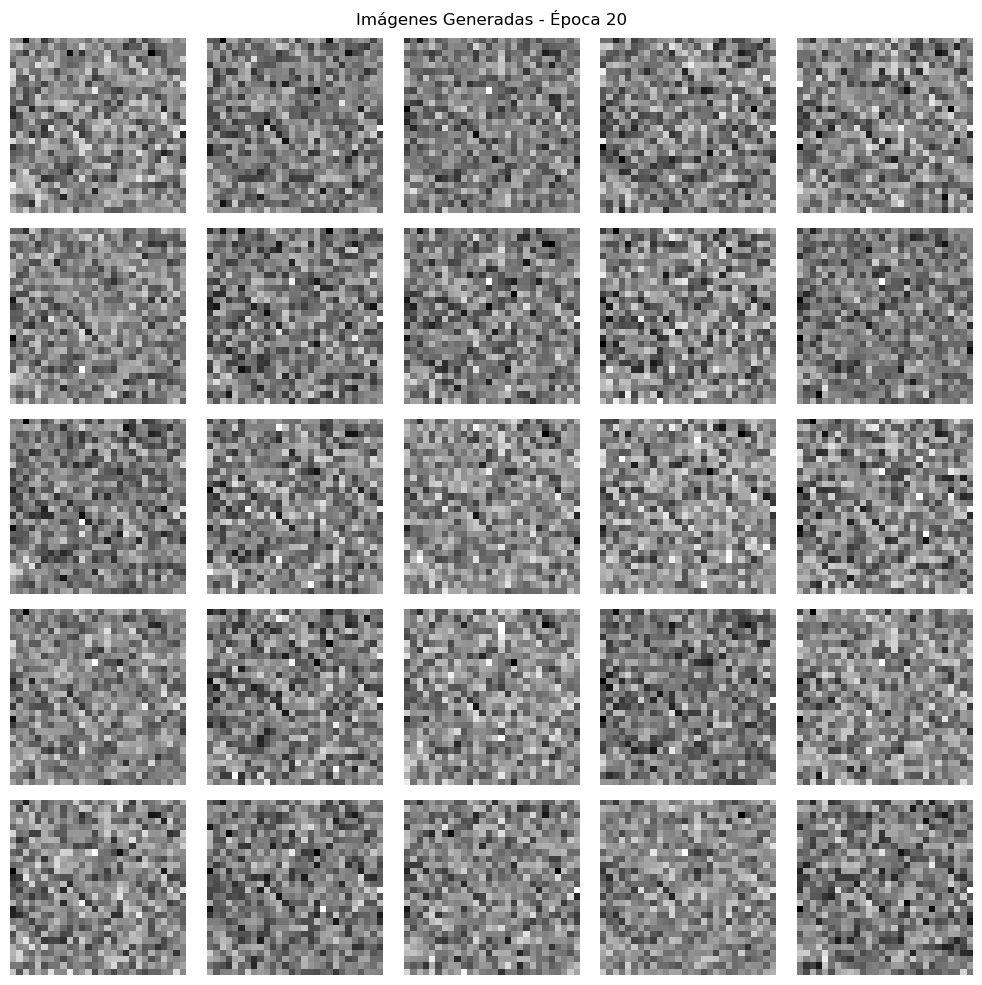

Época 21/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 92.07it/s]


Época [21/50] | D Loss: 20.6526 | G Loss: 0.0000


Época 22/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 92.97it/s]


Época [22/50] | D Loss: 22.0622 | G Loss: 0.0000


Época 23/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 94.02it/s]


Época [23/50] | D Loss: 23.0785 | G Loss: 0.0000


Época 24/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 93.05it/s]


Época [24/50] | D Loss: 25.1429 | G Loss: 0.0000


Época 25/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 95.23it/s]


Época [25/50] | D Loss: 26.7893 | G Loss: 0.0000


Época 26/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 96.43it/s]


Época [26/50] | D Loss: 29.2417 | G Loss: 0.0000


Época 27/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 93.33it/s]


Época [27/50] | D Loss: 31.0454 | G Loss: 0.0000


Época 28/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 92.58it/s]


Época [28/50] | D Loss: 33.0066 | G Loss: 0.0000


Época 29/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 93.18it/s]


Época [29/50] | D Loss: 35.6659 | G Loss: 0.0000


Época 30/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 97.42it/s]


Época [30/50] | D Loss: 37.8206 | G Loss: 0.0000


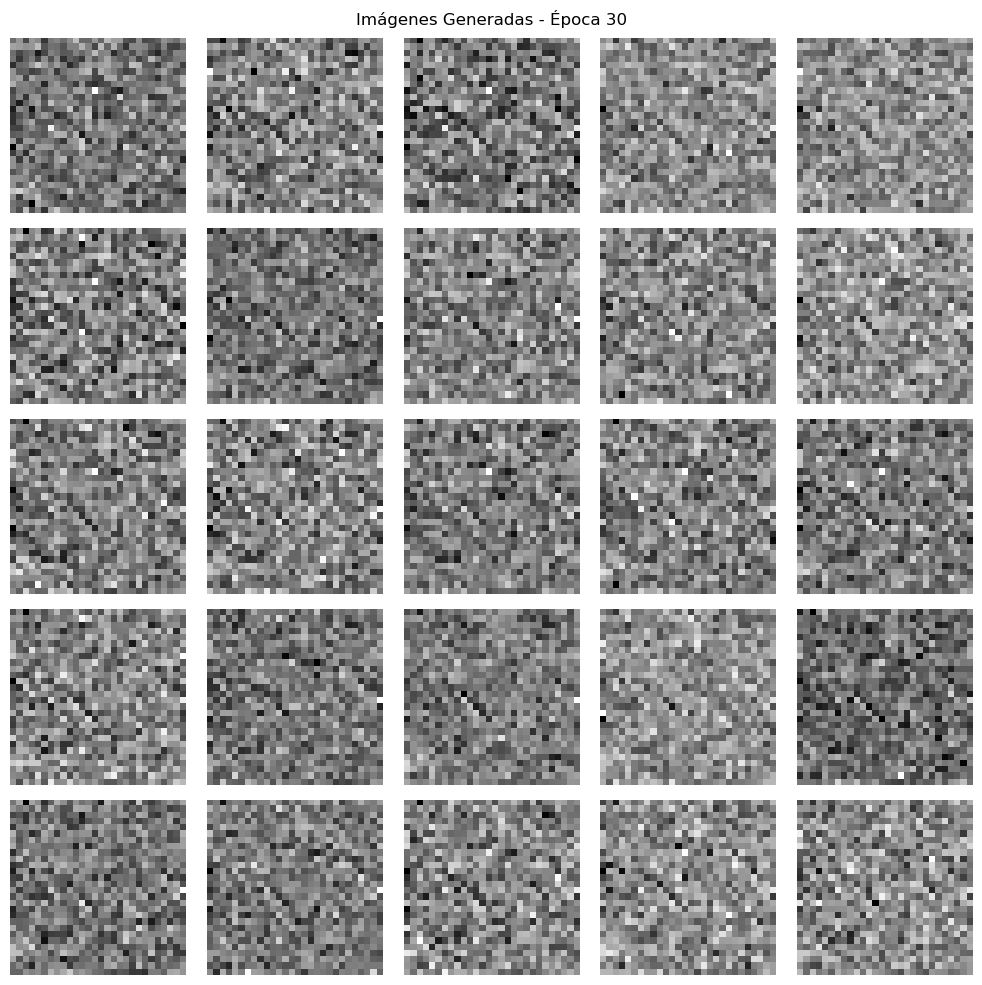

Época 31/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 92.54it/s]


Época [31/50] | D Loss: 40.1569 | G Loss: 0.0000


Época 32/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 92.62it/s]


Época [32/50] | D Loss: 42.5504 | G Loss: 0.0000


Época 33/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 92.79it/s]


Época [33/50] | D Loss: 45.1390 | G Loss: 0.0000


Época 34/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 93.79it/s]


Época [34/50] | D Loss: 47.7132 | G Loss: 0.0000


Época 35/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 94.70it/s]


Época [35/50] | D Loss: 50.6333 | G Loss: 0.0000


Época 36/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 94.43it/s]


Época [36/50] | D Loss: 53.2812 | G Loss: 0.0000


Época 37/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 93.75it/s]


Época [37/50] | D Loss: 55.9388 | G Loss: 0.0000


Época 38/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 97.03it/s]


Época [38/50] | D Loss: 57.9305 | G Loss: 0.0000


Época 39/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 95.65it/s]


Época [39/50] | D Loss: 60.4720 | G Loss: 0.0000


Época 40/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 96.16it/s]


Época [40/50] | D Loss: 63.0561 | G Loss: 0.0000


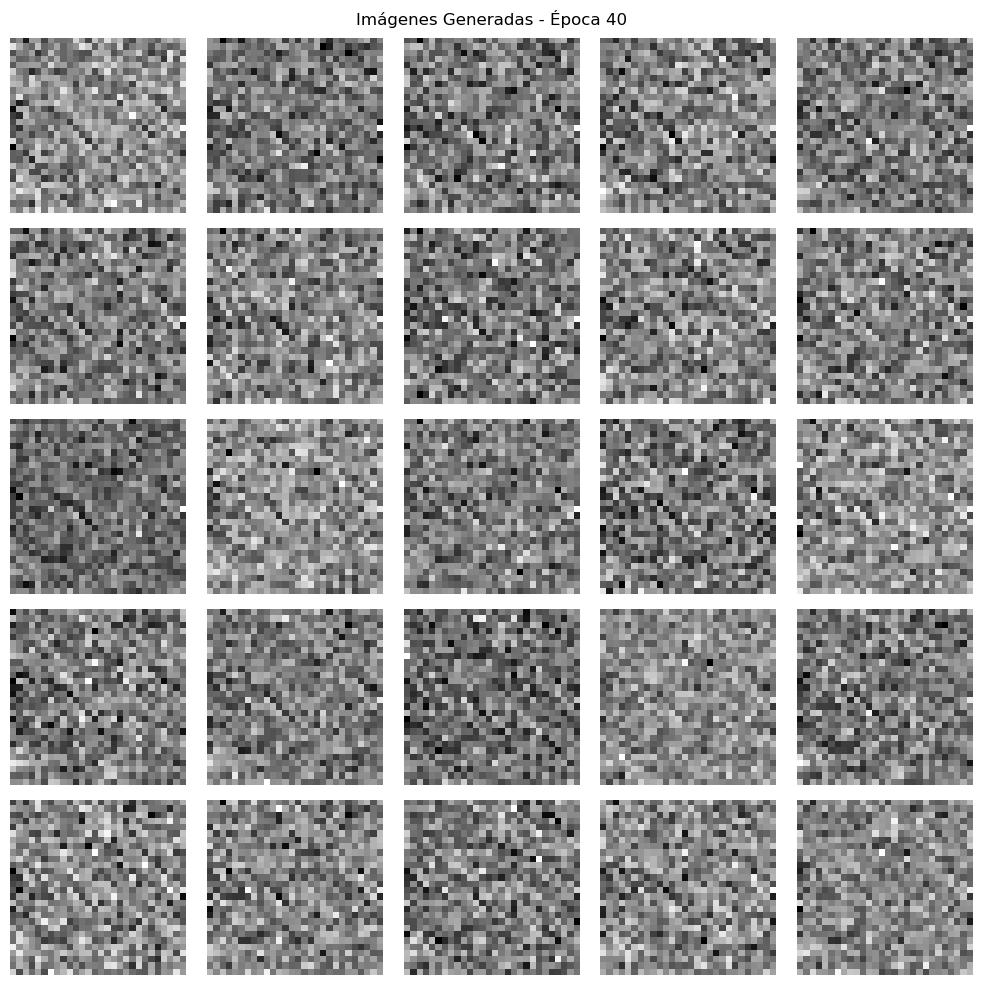

Época 41/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 95.15it/s]


Época [41/50] | D Loss: 64.9814 | G Loss: 0.0000


Época 42/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 96.26it/s]


Época [42/50] | D Loss: 67.4003 | G Loss: 0.0000


Época 43/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 94.61it/s]


Época [43/50] | D Loss: 69.5747 | G Loss: 0.0000


Época 44/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 94.11it/s]


Época [44/50] | D Loss: 71.8360 | G Loss: 0.0000


Época 45/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 96.61it/s]


Época [45/50] | D Loss: 74.3306 | G Loss: 0.0000


Época 46/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 96.88it/s]


Época [46/50] | D Loss: 76.0477 | G Loss: 0.0000


Época 47/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 95.27it/s]


Época [47/50] | D Loss: 77.6262 | G Loss: 0.0000


Época 48/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 94.41it/s]


Época [48/50] | D Loss: 78.6408 | G Loss: 0.0000


Época 49/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 95.52it/s]


Época [49/50] | D Loss: 81.0441 | G Loss: 0.0000


Época 50/50: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 85.00it/s]


Época [50/50] | D Loss: 82.0526 | G Loss: 0.0000


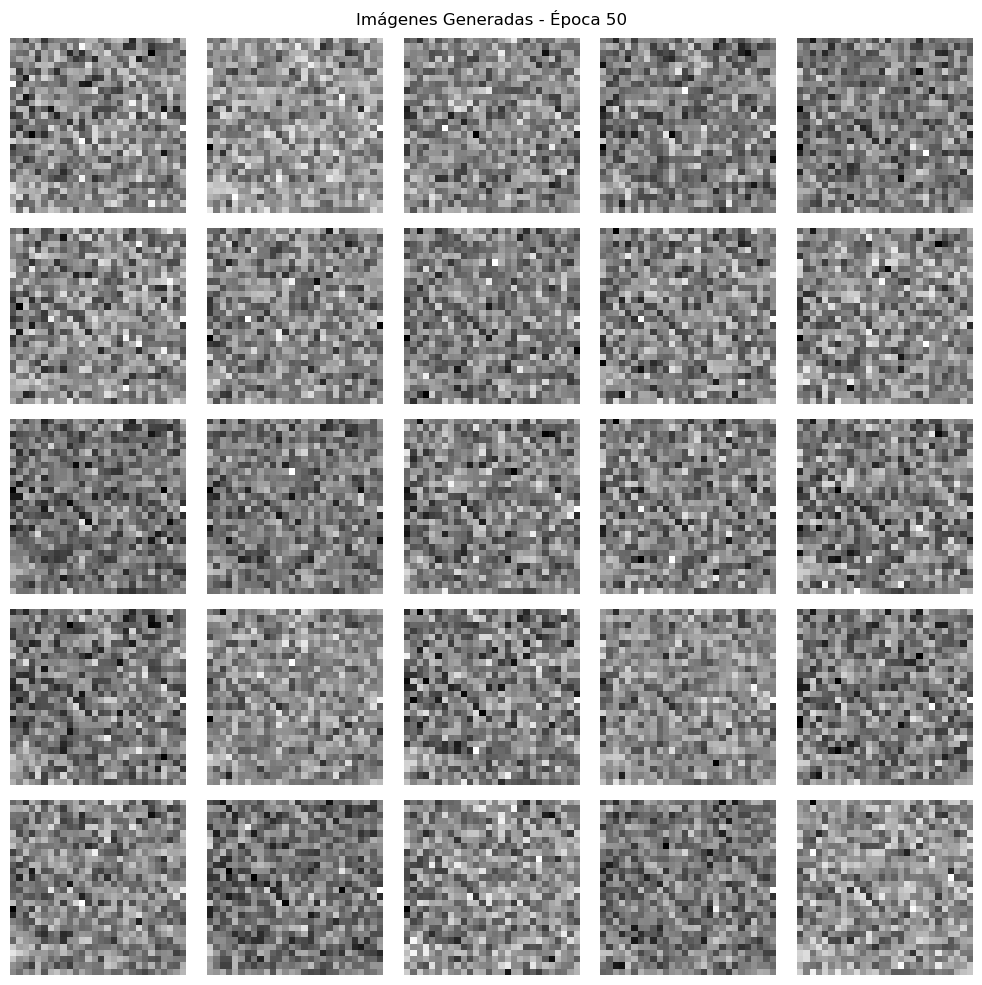


¡Entrenamiento completado!


In [9]:
# TODO: Implementar el loop de entrenamiento de la GAN
# Este es el núcleo del algoritmo GAN

# Listas para guardar pérdidas
g_losses = []
d_losses = []

print("Iniciando entrenamiento...")
for epoch in range(EPOCHS):
    epoch_g_loss = 0
    epoch_d_loss = 0
    
    for i, (real_imgs,) in enumerate(tqdm(dataloader, desc=f"Época {epoch+1}/{EPOCHS}")):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(DEVICE)
        
        # Etiquetas
        real_labels = torch.ones(batch_size, 1).to(DEVICE)
        fake_labels = torch.zeros(batch_size, 1).to(DEVICE)
        
        # =====================
        # Entrenar Discriminador
        # =====================
        optimizer_D.zero_grad()
        
        # TODO: Pérdida en imágenes reales
        real_outputs = discriminator(real_imgs)
        d_loss_real = criterion(real_outputs, real_labels)
        
        # TODO: Generar imágenes falsas
        z = torch.randn(batch_size, LATENT_DIM).to(DEVICE)
        fake_imgs = fake_imgs = generator(z)  #generar imágenes con el generador
        
        # TODO: Pérdida en imágenes falsas
        fake_outputs = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        
        # Pérdida total del discriminador
        d_loss = d_loss_real + d_loss_fake #suma de d_loss_real y d_loss_fake
        d_loss.backward()
        optimizer_D.step()
        
        # =================
        # Entrenar Generador
        # =================
        optimizer_G.zero_grad()
        
        # TODO: Generar nuevas imágenes falsas
        z = torch.randn(batch_size, LATENT_DIM).to(DEVICE)
        fake_imgs = generator(z)
        
        # TODO: El generador quiere que el discriminador clasifique sus imágenes como reales
        fake_outputs = discriminator(fake_imgs) # pasar fake_imgs por el discriminador
        g_loss =  criterion(fake_outputs, real_labels) # alcular pérdida contra real_labels
        
        g_loss.backward()
        optimizer_G.step()
        
        # Acumular pérdidas
        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
    
    # Promediar pérdidas
    avg_g_loss = epoch_g_loss / len(dataloader)
    avg_d_loss = epoch_d_loss / len(dataloader)
    
    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)
    
    print(f"Época [{epoch+1}/{EPOCHS}] | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")
    
    # Generar y mostrar imágenes cada 10 épocas
    if (epoch + 1) % 10 == 0 or epoch == 0:
        generate_and_save_images(generator, epoch+1, LATENT_DIM)

print("\n¡Entrenamiento completado!")

## Parte 8: Visualizar curvas de pérdida

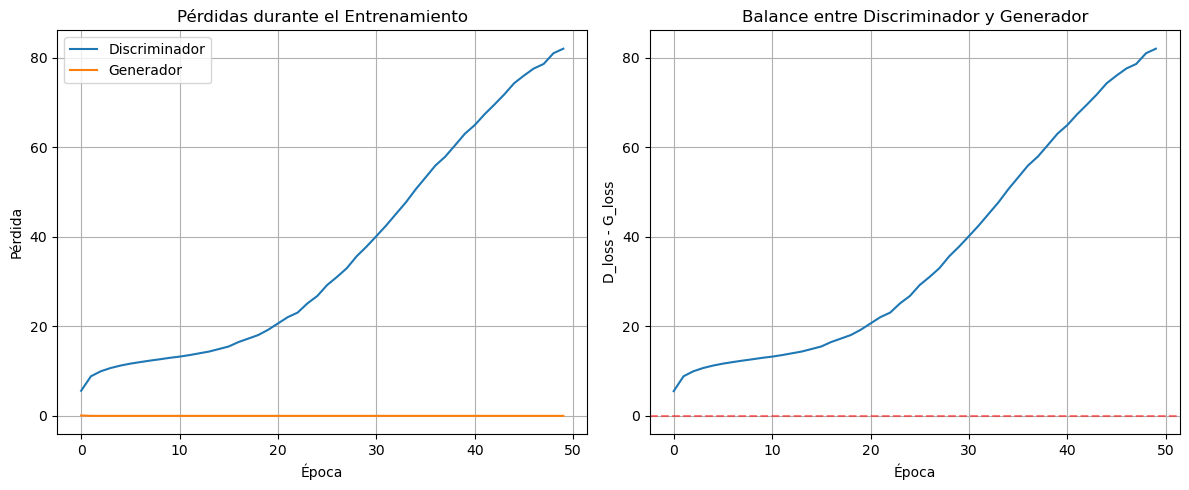

In [10]:
# TODO: Graficar las pérdidas del generador y discriminador
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminador')
plt.plot(g_losses, label='Generador')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdidas durante el Entrenamiento')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
# COMPLETA: Graficar la diferencia entre las pérdidas
diff = np.array(d_losses) - np.array(g_losses)
plt.plot(diff)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Época')
plt.ylabel('D_loss - G_loss')
plt.title('Balance entre Discriminador y Generador')
plt.grid(True)

plt.tight_layout()
plt.show()

## Parte 9: Generar imágenes finales

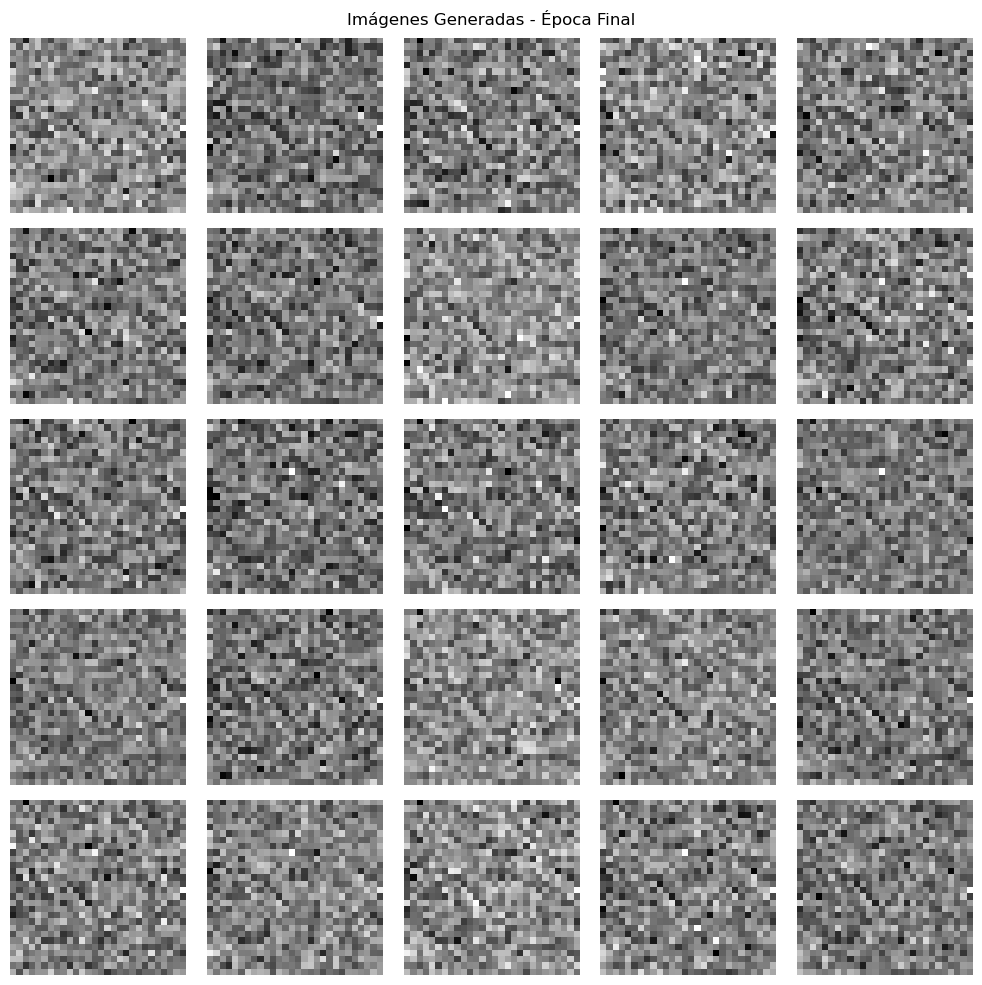

In [11]:
# Generar un batch final de imágenes
generate_and_save_images(generator, 'Final', LATENT_DIM, n_images=25)

## Parte 10: Interpolación en el espacio latente

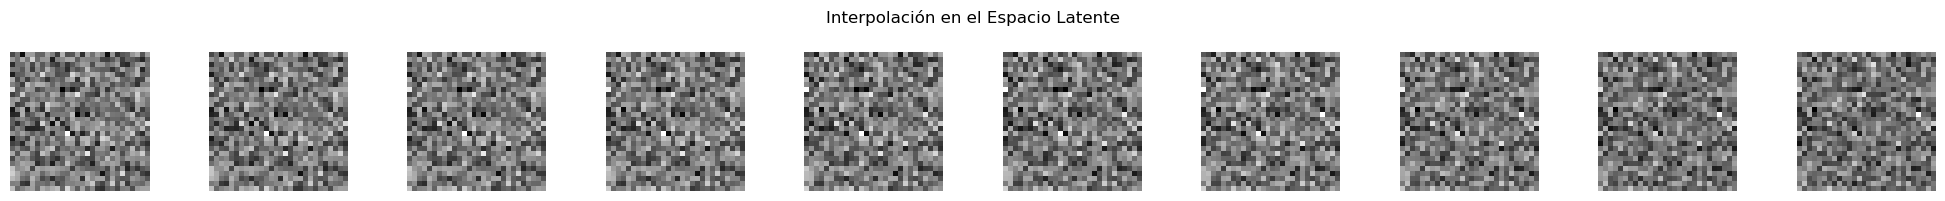

In [12]:
# TODO: Realizar interpolación entre dos puntos del espacio latente
# Esto demuestra la continuidad del espacio aprendido

def interpolate_latent_space(generator, n_steps=10):
    generator.eval()
    
    # TODO: Generar dos vectores latentes aleatorios
    z1 = torch.randn(1, LATENT_DIM).to(DEVICE)
    z2 = torch.randn(1, LATENT_DIM).to(DEVICE)
    
    # TODO: Crear interpolación lineal entre z1 y z2
    alphas = np.linspace(0, 1, n_steps)
    interpolated = []
    
    with torch.no_grad():
        for alpha in alphas:
            # COMPLETA: Interpolar entre z1 y z2
            z =(1 - alpha) * z1 + alpha * z2
            img = generator(z)
            interpolated.append(img.cpu().numpy())
    
    # Visualizar
    fig, axes = plt.subplots(1, n_steps, figsize=(20, 2))
    for i, ax in enumerate(axes):
        img = (interpolated[i][0] + 1) / 2  # Desnormalizar
        ax.imshow(img.reshape(28, 28), cmap='gray')
        ax.axis('off')
    
    plt.suptitle('Interpolación en el Espacio Latente')
    plt.tight_layout()
    plt.show()
    
    generator.train()

# Ejecutar interpolación
interpolate_latent_space(generator, n_steps=10)

## Parte 11: Exploración del espacio latente

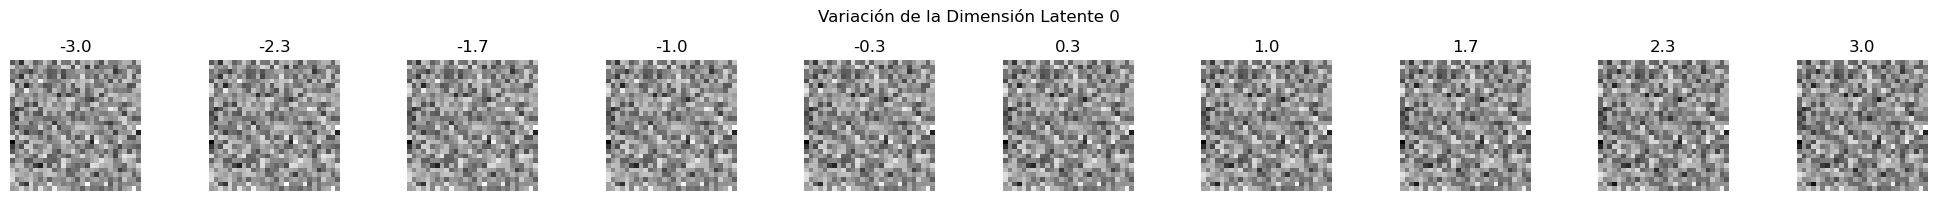

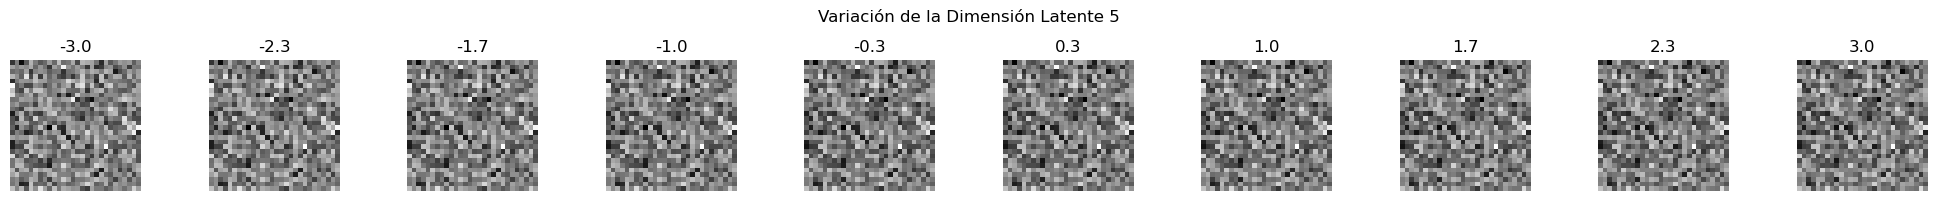

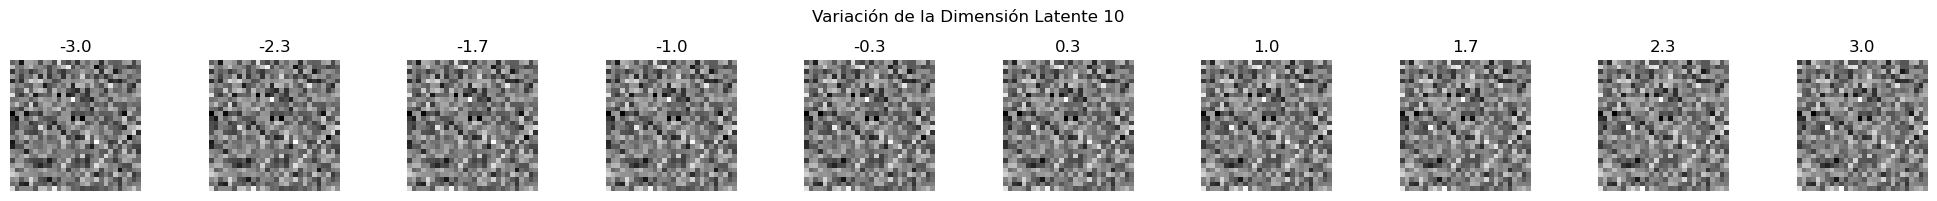

In [13]:
# TODO: Generar múltiples imágenes variando una sola dimensión del espacio latente
def explore_latent_dimension(generator, dim_idx=0, n_steps=10, value_range=(-3, 3)):
    """
    Explora cómo cambia la imagen al variar una dimensión específica del espacio latente
    """
    generator.eval()
    
    # Vector latente base (fijo)
    z_base = torch.randn(1, LATENT_DIM).to(DEVICE)
    
    # TODO: Variar solo la dimensión dim_idx
    values = np.linspace(value_range[0], value_range[1], n_steps)
    images = []
    
    with torch.no_grad():
        for val in values:
            z = z_base.clone()
            # COMPLETA: Modificar la dimensión dim_idx
            z[0, dim_idx] = val
            img = generator(z)
            images.append(img.cpu().numpy())
    
    # Visualizar
    fig, axes = plt.subplots(1, n_steps, figsize=(20, 2))
    for i, ax in enumerate(axes):
        img = (images[i][0] + 1) / 2
        ax.imshow(img.reshape(28, 28), cmap='gray')
        ax.set_title(f'{values[i]:.1f}')
        ax.axis('off')
    
    plt.suptitle(f'Variación de la Dimensión Latente {dim_idx}')
    plt.tight_layout()
    plt.show()
    
    generator.train()

# Explorar diferentes dimensiones
for dim in [0, 5, 10]:
    explore_latent_dimension(generator, dim_idx=dim, n_steps=10)

## Preguntas de reflexión:

1. **¿Cómo evolucionaron las pérdidas del generador y discriminador?** ¿Se alcanzó un equilibrio?

2. **¿Qué pasa si el discriminador es mucho mejor que el generador?** ¿Y viceversa?

3. **¿Las imágenes generadas son realistas?** ¿En qué época empezaron a verse bien?

4. **¿Qué revela la interpolación sobre el espacio latente?** ¿Es continuo y suave?

5. **¿Qué técnicas podrías implementar para mejorar la calidad de las imágenes?**
   - Sugerencias: Batch Normalization, diferentes arquitecturas (DCGAN), Wasserstein Loss, etc.

6. **¿Qué desafíos presenta el entrenamiento de GANs?**

**Escribe tus respuestas aquí:**

1. Las pérdidas del generador y discriminador al inicio fluctúan mucho; con las épocas tienden a estabilizarse y muestran cierto equilibrio, aunque nunca es perfecto.
2. Si el discriminador es mucho mejor, el generador recibe gradientes débiles y no aprende; si el generador es mucho mejor, el discriminador no puede diferenciar y la pérdida se vuelve inestable.
3. Las imágenes generadas empiezan a parecer dígitos reales después de varias épocas, generalmente entre la 50 y 100, antes se ven borrosas o incompletas.
4. La interpolación en el espacio latente muestra cambios suaves en los dígitos, indicando que el espacio es continuo y que cada dimensión controla características específicas.
5. Para mejorar la calidad se pueden usar Batch Normalization, arquitecturas DCGAN, Wasserstein Loss, técnicas de regularización y aumento de datos.
6. El entrenamiento de GANs es inestable, sensible a la elección de hiperparámetros, puede presentar colapso de modo y requiere balance entre generador y discriminador.